In [174]:
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Exploratory Data Analysis (EDA)

## Seasons data frame

In [ ]:
#consulta de datos de seasons (match) que se llame season_df. La consulta se hace desde GCP

In [ ]:
#consulta de datos de statistics que se llame statistics_df

In [7]:
seasons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1140 non-null   int64  
 1   season         1140 non-null   int64  
 2   match_date     1140 non-null   object 
 3   match_id       1140 non-null   int64  
 4   local_team     1140 non-null   object 
 5   local_team_id  1140 non-null   int64  
 6   away_team      1140 non-null   object 
 7   away_team_id   1140 non-null   int64  
 8   local_goals    1048 non-null   float64
 9   away_goals     1048 non-null   float64
dtypes: float64(2), int64(5), object(3)
memory usage: 89.2+ KB


Explore NA in season data frame

<AxesSubplot:>

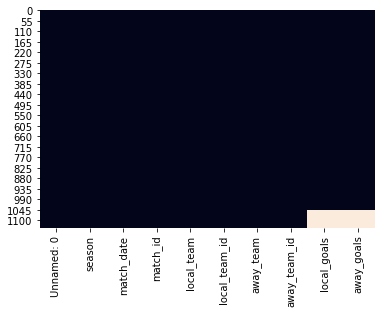

In [8]:
sns.heatmap(seasons_df.isnull(), cbar=False)

As you can see we have a few missing values on the local and away goals. So, we will count the missing values and underestand for what reason we have it.

In [9]:
local_na = len(seasons_df[seasons_df['local_goals'].isnull()])
away_na = len(seasons_df[seasons_df['away_goals'].isnull()])

print(f"The NA's for local goals are:{local_na}")
print(f"The NA's for local goals are:{away_na}")

The NA's for local goals are:92
The NA's for local goals are:92


In [10]:
seasons_df[seasons_df['local_goals'].isnull()]

,Unnamed: 0,season,match_date,match_id,local_team,local_team_id,away_team,away_team_id,local_goals,away_goals
930,170,2021,2021-12-18T15:00:00+00:00,710726,Aston Villa,66,Burnley,44,NaN,NaN
931,171,2021,2022-04-20T18:45:00+00:00,710727,Everton,45,Leicester,46,NaN,NaN
942,182,2021,2022-04-06T18:30:00+00:00,710738,Burnley,44,Everton,45,NaN,NaN
966,206,2021,2022-01-01T15:00:00+00:00,710762,Leicester,46,Norwich,71,NaN,NaN
977,217,2021,2022-01-16T16:30:00+00:00,710773,Tottenham,47,Arsenal,42,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1135,375,2021,2022-05-22T15:00:00+00:00,710931,Crystal Palace,52,Manchester United,33,NaN,NaN
1136,376,2021,2022-05-22T15:00:00+00:00,710932,Leicester,46,Southampton,41,NaN,NaN
1137,377,2021,2022-05-22T15:00:00+00:00,710933,Liverpool,40,Wolves,39,NaN,NaN
1138,378,2021,2022-05-22T15:00:00+00:00,710934,Manchester City,50,Aston Villa,66,NaN,NaN


As you can see, according to the match date the missing values correspond to matches for the rest of the year 2022. We will explore if it is true. 

In [11]:
df_null = seasons_df[seasons_df['local_goals'].isnull()].copy()
df_null['anio'] = df_null['match_date'].astype(str).str[0:4]
df_null['anio'] = df_null['anio'].astype(int)
df_null.anio.unique()

array([2021, 2022])

In [12]:
df_null[df_null['anio'] == 2021]

,Unnamed: 0,season,match_date,match_id,local_team,local_team_id,away_team,away_team_id,local_goals,away_goals,anio
930,170,2021,2021-12-18T15:00:00+00:00,710726,Aston Villa,66,Burnley,44,NaN,NaN,2021


According to the schedule of the competition this match was posposed without results. See the next image:

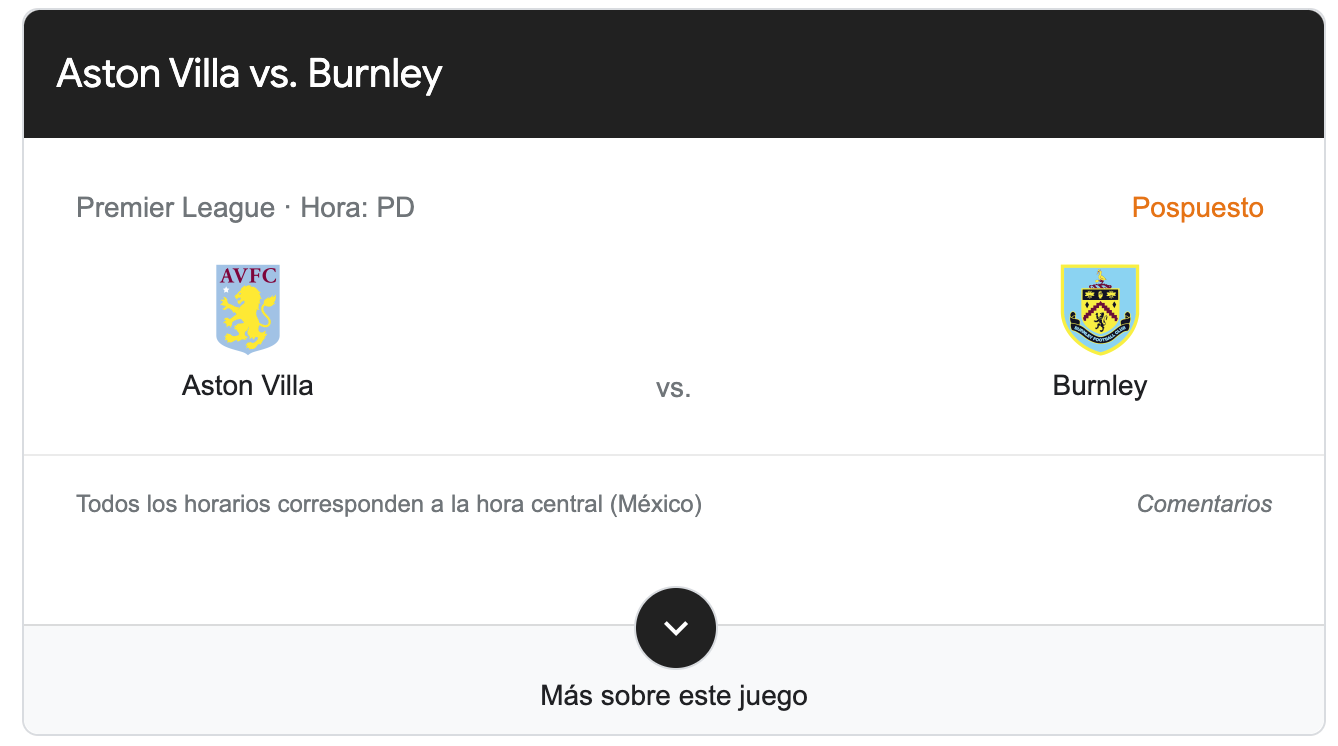

In conclusion it is possible to us delete the null values of our data set to do the analysis. 

In [13]:
seasons_df = seasons_df[seasons_df['away_goals'].notnull()]

<AxesSubplot:>

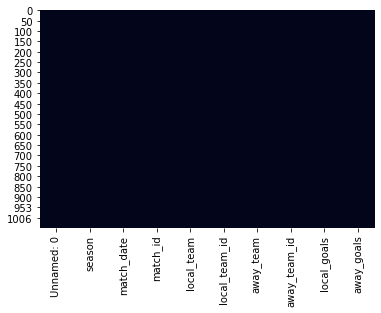

In [14]:
sns.heatmap(seasons_df.isnull(), cbar=False)

Now, we will reviw the distribution for the local team and away team goals.

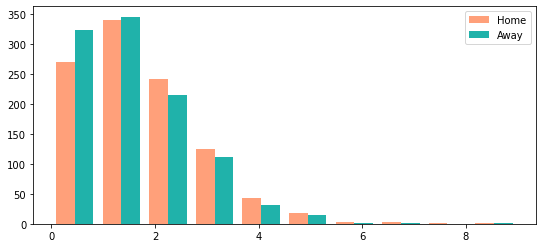

In [15]:
fig, ax = plt.subplots(figsize=(9,4)) 
plt.hist(seasons_df[['local_goals', 'away_goals']].values, 
          label=['Home', 'Away'], color=["#FFA07A", "#20B2AA"])
plt.legend(['Home', 'Away'])
plt.show()

The histogram show simple, but interesting things. For example, we can see that the away team with zero goals more frequent that the home team with zero goals and this is important for our model because we can think that this condition (home oe away) represent an importan factor for the analysis.

On the other hand, we can notice there are teams that in a match perfomred more than six goals, but as you can see this is bit frequently event, under this condition we suggest remove this atypical result because it can represent a bias factor for proposal model.

The matches with more than 6 goals form one team are:

In [16]:
pd.DataFrame(seasons_df[["local_goals", "away_goals"]].max(axis=1).value_counts())

,0
2.0,343
1.0,299
3.0,219
4.0,75
0.0,68
5.0,32
6.0,5
7.0,4
9.0,2
8.0,1


There are only 12 mathes where one of the teams performed more than 6 goals, 5 matches with 6 goals, 4 with 7, 2 with 9 and 1 with 8 goals, for this reason we will delete of the table in order to ajust our model.

In [17]:
seasons_df = seasons_df[seasons_df["local_goals"]<6]

In [18]:
seasons_df = seasons_df[seasons_df["away_goals"]<6]

Finally, the histogram of goals by away and home condition removing the atypical results is:

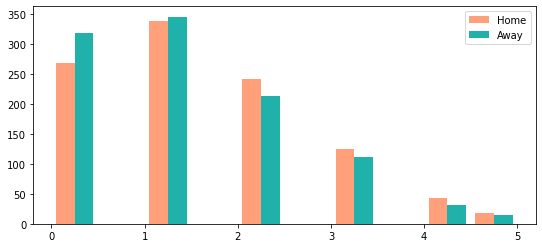

In [19]:
fig, ax = plt.subplots(figsize=(9,4)) 
plt.hist(seasons_df[['local_goals', 'away_goals']].values, color=["#FFA07A", "#20B2AA"])
plt.legend(['Home', 'Away'])
plt.show()

## Statistics data frame

In [42]:
statistics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1879 entries, 0 to 1878
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   page             1879 non-null   int64  
 1   season           1879 non-null   int64  
 2   player_id        1879 non-null   int64  
 3   player_name      1879 non-null   object 
 4   age              1874 non-null   float64
 5   height           1622 non-null   object 
 6   weight           1509 non-null   object 
 7   injured          1879 non-null   bool   
 8   team_id          1879 non-null   int64  
 9   appearences      1832 non-null   float64
 10  minutes          1832 non-null   float64
 11  position         1879 non-null   object 
 12  rating           1310 non-null   float64
 13  shots            1130 non-null   float64
 14  goals            1832 non-null   float64
 15  assists          651 non-null    float64
 16  passes_accuracy  1319 non-null   float64
 17  total_duels   

Exploring NA values by column

In [43]:
statistics_df.shape

(1879, 19)

<AxesSubplot:>

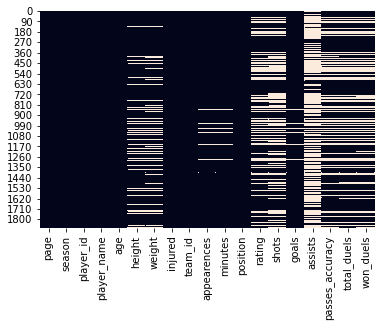

In [44]:
sns.heatmap(statistics_df.isnull(), cbar=False)

Argumentar si las asistencias son necesarias porque se ven muchos nulos. Hacer un comparativo por posisción de las asistencias a ver si tiene que ver con eso, adicional considerar el hecho de que el rating puede contener esa información, se puede sacar un promedio diferenciado con o sin asistencias para argumentar. 

We have a lot variable with null values. The idea is to inspect eache one to underestand the reason of in that case if the variable is neccesary. So, in the first place we will analize assists variable. If we compare the assist values with the position it is possible to underestan for wath reason a lot of this values are null. 

In [45]:
statistics_df.groupby("position")["assists"].count()

position
Attacker      179
Defender      182
Goalkeeper      6
Midfielder    284
Name: assists, dtype: int64

In [46]:
statistics_df.groupby("position")["assists"].apply(lambda x: x.isnull().sum())

position
Attacker      203
Defender      434
Goalkeeper    207
Midfielder    384
Name: assists, dtype: int64

As you can see, the position with more NaN's values is the goalkeeper and it is common in the futbal. We can see that defender is a position with a not assist and this is natural. But to understand if this variable is informative or not we can compre the ratings, and we can assume that if the average rating per player is diferent then this variable will be necessary to consider in our model on the other hand we can remove. 

In [47]:
statistics_df[statistics_df['assists'].notnull()].groupby("position")["rating","appearences"].mean()

<ipython-input-47-c872696174e4>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  statistics_df[statistics_df['assists'].notnull()].groupby("position")["rating","appearences"].mean()


,rating,appearences
position,,
Attacker,6.887632,24.452514
Defender,6.919599,22.818681
Goalkeeper,6.941024,29.500000
Midfielder,6.927224,23.887324


In [48]:
statistics_df[statistics_df['assists'].isnull()].groupby("position")["rating"].mean()

position
Attacker      6.558436
Defender      6.760574
Goalkeeper    6.782360
Midfielder    6.624785
Name: rating, dtype: float64

We can see that the rating increase when the players have assist, that means that the rating contain the information about assist and we can consider remove of the study. More over, if the rating is very informative that means that we can think on the appearence varaibale and consider: while more rating more appearence. Let's see!

In [49]:
statistics_df[statistics_df['assists'].notnull()].groupby("position")["rating","appearences"].mean()

<ipython-input-49-c872696174e4>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  statistics_df[statistics_df['assists'].notnull()].groupby("position")["rating","appearences"].mean()


,rating,appearences
position,,
Attacker,6.887632,24.452514
Defender,6.919599,22.818681
Goalkeeper,6.941024,29.500000
Midfielder,6.927224,23.887324


In [50]:
statistics_df[statistics_df['assists'].isnull()].groupby("position")["rating","appearences"].mean()

<ipython-input-50-61baa7ce6ed0>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  statistics_df[statistics_df['assists'].isnull()].groupby("position")["rating","appearences"].mean()


,rating,appearences
position,,
Attacker,6.558436,5.045918
Defender,6.760574,8.448687
Goalkeeper,6.782360,7.778325
Midfielder,6.624785,6.159780


With this last result, we can consider that the rating contains information about the appearence as the assist. Finally, for now shots, total duel and won duels are less informative variables because depends of appearence and in some cases of the assist and therefore we can assume that all this information is in the rating variable. 

The last "problem", the rating variable as a lot of nulls, but depends of the appearence. 

In [51]:
pd.concat([statistics_df[statistics_df["appearences"] == 0].head(),statistics_df[statistics_df["appearences"] == 0].tail()])

,page,season,player_id,player_name,age,height,weight,injured,team_id,appearences,minutes,position,rating,shots,goals,assists,passes_accuracy,total_duels,won_duels
0,1,2019,160,M. Vorm,38.0,183 cm,84 kg,False,47,0.0,0.0,Goalkeeper,NaN,NaN,0.0,NaN,NaN,NaN,NaN
5,1,2019,18789,Gomes,40.0,191 cm,91 kg,False,38,0.0,0.0,Goalkeeper,NaN,NaN,0.0,NaN,NaN,NaN,NaN
19,1,2019,138936,K. Hayden,18.0,NaN,NaN,False,66,0.0,0.0,Midfielder,NaN,NaN,0.0,NaN,NaN,NaN,NaN
23,2,2019,2584,L. Campana,22.0,187 cm,79 kg,False,39,0.0,0.0,Attacker,NaN,NaN,0.0,NaN,NaN,NaN,NaN
31,2,2019,18871,Matthew David Butcher,25.0,188 cm,83 kg,False,35,0.0,0.0,Midfielder,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1857,33,2020,138777,Faustino Adebola Rasheed Anjorin,21.0,185 cm,73 kg,False,49,0.0,0.0,Midfielder,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1858,33,2020,277714,Kyron Gordon,20.0,NaN,NaN,False,62,0.0,0.0,Defender,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1861,34,2020,895,James David Garner,21.0,182 cm,NaN,False,33,0.0,0.0,Midfielder,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1868,34,2020,19159,S. Johansen,31.0,182 cm,78 kg,False,36,0.0,0.0,Midfielder,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1878,34,2020,315237,Will Osula,19.0,180 cm,81 kg,False,62,0.0,0.0,Attacker,NaN,NaN,0.0,NaN,NaN,NaN,NaN


Note that our ratings are null values when the player has not appearences and this is obvious, becasus we can not mesure a performance of a player without minutes on the pitch. Then, we remove the null values of rating variable because is neccesary and it is the unique variable of study segmented by position. 

In [52]:
statistics_df1 = statistics_df[statistics_df["rating"].notnull()][["team_id","season","position","rating"]]

In [53]:
statistics_df1.head()

,team_id,season,position,rating
1,50,2019,Attacker,7.160869
2,45,2019,Midfielder,6.854285
3,45,2019,Defender,6.887500
4,46,2019,Defender,6.680000
6,38,2019,Defender,6.478571


array([[<AxesSubplot:title={'center':'Attacker'}>,
        <AxesSubplot:title={'center':'Defender'}>],
       [<AxesSubplot:title={'center':'Goalkeeper'}>,
        <AxesSubplot:title={'center':'Midfielder'}>]], dtype=object)

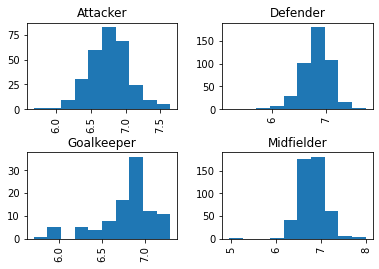

In [54]:
statistics_df['rating'].hist(by=statistics_df['position'])
#statistics_df.position.hist(by = statistics_df.rating)

Despite that the mean of each position about rating is near of seven the dispertion of each one suggest that is better to consider for team_id each positon as a explanatory variable. In order to aggregate by team_id and join with the season data frame we consider the average of the ratings.

In [162]:
rating_df = pd.pivot_table(statistics_df1, values = 'rating', index = ['team_id'],
                          columns=['position'], aggfunc = np.mean)

#table = pd.pivot_table(df, values='D', index=['A', 'B'],
#                    columns=['C'], aggfunc=np.sum)

In [154]:
rating_df.head()

position,Attacker,Defender,Goalkeeper,Midfielder
team_id,,,,
33,6.779548,6.885638,6.889799,6.956651
34,6.719936,6.736841,6.644696,6.702117
35,6.542857,6.692007,6.905405,6.450000
36,6.762350,6.777739,6.648611,6.682085
38,6.722939,6.698039,6.627778,6.577284


Finally, we only consider the teams in the actual seasos because we want to inference about them. 

In [104]:
current_teams = seasons_df[seasons_df["season"] == 2021][["local_team_id"]].drop_duplicates()

In [106]:
current_teams['flag'] = 1

In [115]:
current_teams
#rating_df

,local_team_id,flag
760,55,1
761,44,1
762,49,1
763,45,1
764,46,1
765,33,1
766,34,1
767,71,1
768,47,1
769,38,1


In [163]:
rating_df = pd.merge(rating_df,current_teams,how='left',left_on='team_id', right_on='local_team_id',)

In [164]:
rating_df.head()

,Attacker,Defender,Goalkeeper,Midfielder,local_team_id,flag
0,6.779548,6.885638,6.889799,6.956651,33.0,1.0
1,6.719936,6.736841,6.644696,6.702117,34.0,1.0
2,6.542857,6.692007,6.905405,6.450000,NaN,NaN
3,6.762350,6.777739,6.648611,6.682085,NaN,NaN
4,6.722939,6.698039,6.627778,6.577284,38.0,1.0


In [165]:
rating_df = rating_df[rating_df['flag'].notnull()]

## Referencias
* <https://cloud.google.com/sdk/gcloud/reference/sql/connect>
* <https://docs.sqlalchemy.org/en/14/core/tutorial.html#deletes>
* <https://cloud.google.com/sql/docs/postgres/connect-app-engine-standard#private-ip_1>
* https://docs.sqlalchemy.org/en/14/core/metadata.html

In [ ]:
Feature engineering